In [1]:

import pandas
import os
from metric_utils import *
import torch
import ast
import numpy as np
from swarm_visualizer.boxplot import  plot_paired_boxplot
from swarm_visualizer.utility.general_utils import save_fig, set_plot_properties
from matplotlib import pyplot as plt
import warnings
import seaborn as sns
from seaborn import lineplot,scatterplot
warnings.filterwarnings('ignore')

# Training and Validation Distribution Plots


condition
Clear, Dawn/Dusk     0.060402
Clear, Day           0.626483
Clear, Night         0.018527
Cloudy, Dawn/Dusk    0.007244
Cloudy, Day          0.056666
Cloudy, Night        0.006436
Rainy, Dawn/Dusk     0.018073
Rainy, Day           0.172674
Rainy, Night         0.033495
dtype: float64
condition
Clear, Dawn/Dusk     0.036788
Clear, Day           0.725561
Clear, Night         0.019862
Cloudy, Dawn/Dusk    0.008117
Cloudy, Day          0.022280
Cloudy, Night        0.008290
Rainy, Dawn/Dusk     0.055613
Rainy, Day           0.071848
Rainy, Night         0.051641
dtype: float64


Text(0, 0.5, 'Number of Samples')

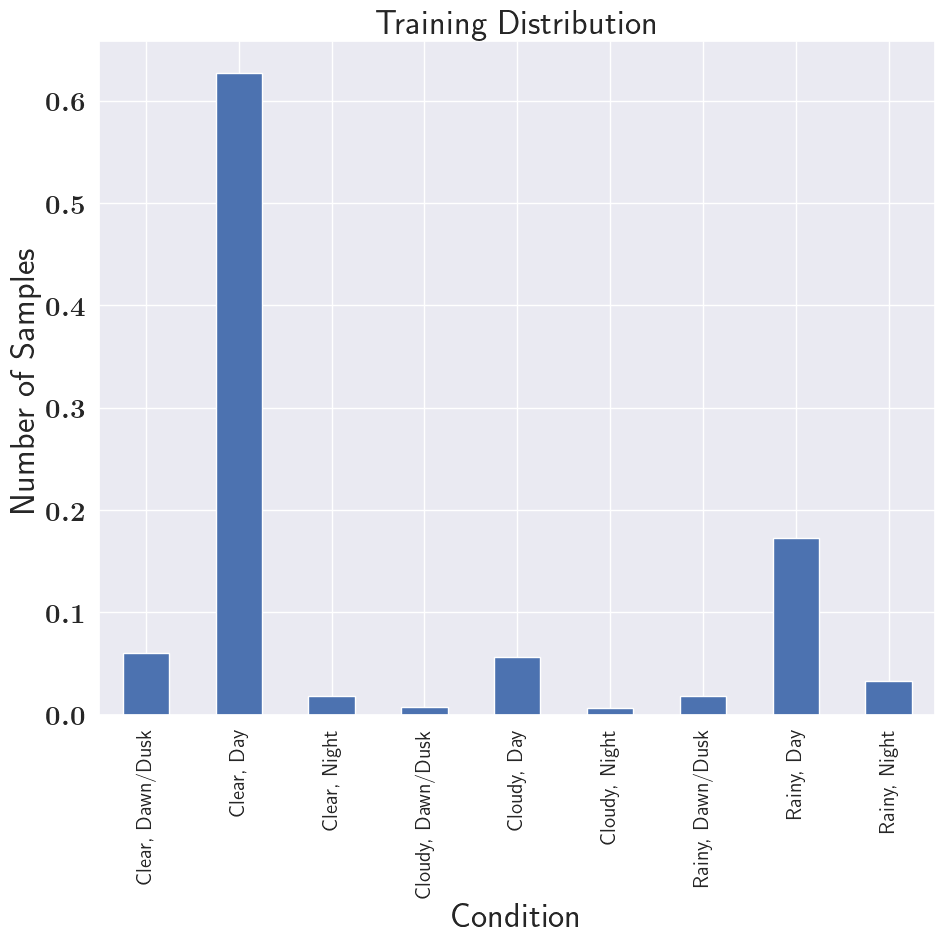

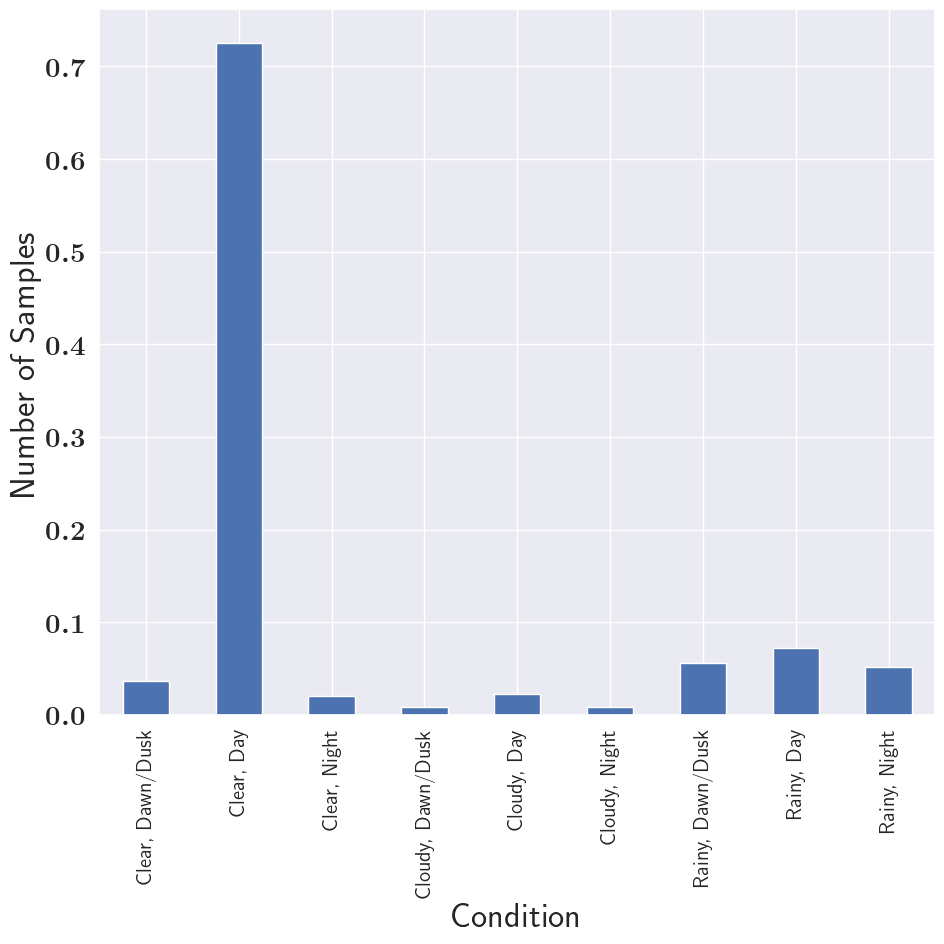

In [51]:
# Training Distribution Plots

TRAIN_FILENAME = '../../waymo_open_data/waymo_env_conditions_train.csv'
TEST_FILENAME = '../../waymo_open_data/waymo_env_conditions_val.csv'

train_df = pandas.read_csv(TRAIN_FILENAME)
plt.figure(figsize=(10, 10))
df = train_df.groupby('condition').size()/train_df.shape[0]
print(df)
df.plot(kind='bar')

plt.xlabel('Condition')
plt.ylabel('Number of Samples')
plt.title('Training Distribution')
plt.figure(figsize=(10, 10))
val_df = pandas.read_csv(TEST_FILENAME)
df = val_df.groupby('condition').size()/val_df.shape[0]
print(df)
df.plot(kind='bar')
plt.xlabel('Condition')
plt.ylabel('Number of Samples')


In [35]:
FOLDER = '../tests/'
files = os.listdir(FOLDER)
WAYMO_PALLETE = {
            'undefined' : [0, 0, 0],#1
            'ego_vehicle': [102, 102, 102],#2
            'car': [0, 0, 142], #3
            'truck': [0, 0, 70], #4
            'bus': [0, 60, 100],#5
            'other_large_vehicle': [61, 133, 198],#
            'bicycle': [119, 11, 32],#
            'motorcycle': [0, 0, 230],#
            'trailer': [111, 168, 220],#
            'pedestrian': [220, 20, 60],#10
            'cyclist': [255, 0, 0],#
            'motorcyclist': [180, 0, 0],#
            'bird': [127, 96, 0],#
            'ground_animal': [91, 15, 0],#
            'construction_cone_pole': [230, 145, 56],#15
            'pole': [153, 153, 153],#
            'pedestrian_object': [234, 153, 153],#
            'sign': [246, 178, 107],#
            'traffic_light': [250, 170, 30],#
            'building': [70, 70, 70],#20
            'road': [128, 64, 128],#
            'lane_marker': [234, 209, 220],#
            'road_marker': [217, 210, 233],#
            'sidewalk': [244, 35, 232],#
            'vegetation': [107, 142, 35],#25
            'sky': [70, 130, 180],#
            'ground': [102, 102, 102],#
            'dynamic': [102, 102, 102],#
            'static': [102, 102, 102]#
        }
WAYMO_CLASSES = np.array(list(WAYMO_PALLETE.keys()))
COMPUTE_CLASSES = np.arange(len(WAYMO_CLASSES))[2:-3]
print(WAYMO_CLASSES[COMPUTE_CLASSES])


['car' 'truck' 'bus' 'other_large_vehicle' 'bicycle' 'motorcycle'
 'trailer' 'pedestrian' 'cyclist' 'motorcyclist' 'bird' 'ground_animal'
 'construction_cone_pole' 'pole' 'pedestrian_object' 'sign'
 'traffic_light' 'building' 'road' 'lane_marker' 'road_marker' 'sidewalk'
 'vegetation' 'sky']


# Compile Data


segformer_mit-b3_8xb2-160k_waymo-512x512
mask2former_r50_8xb2-90k_mixedwaymo-512x512
mask2former_swin-t_8xb2-160k_synthwaymo-512x512
mask2former_r50_8xb2-90k_waymo-512x512
mask2former_swin-t_8xb2-160k_mixedwaymo-512x512
mask2former_r50_8xb2-90k_synthwaymo-512x512
segformer_mit-b3_8xb2-160k_synthwaymo-512x512
mask2former_swin-t_8xb2-160k_waymo-512x512
segformer_mit-b3_8xb2-160k_mixedwaymo-512x512


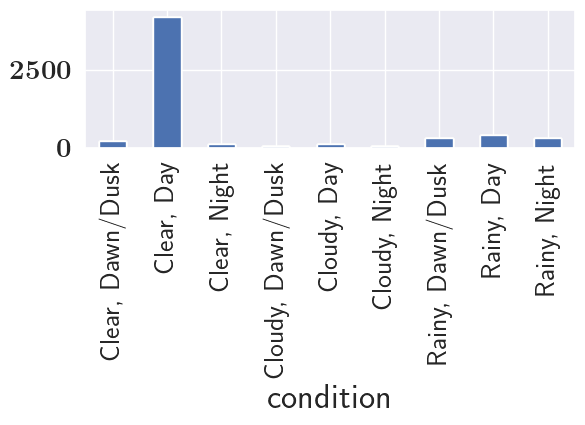

In [36]:
MODEL_DATA= dict()
for file in files:
    if file.endswith('.csv'):
        model = file.split('.')[0]
        df = pandas.read_csv(FOLDER + file)
        # Convert each relevant column to a Torch tensor
        MODEL_DATA[model] = df
        # print(len(df))
        # print(df.groupby('condition').size())
        # barplot
        print(model)
        df.groupby('condition').size().plot(kind='bar')
    
def string_to_tensor(tensor_string):
    # Convert string representation of a tensor to an actual tensor
    # Use ast.literal_eval to safely evaluate the string
    #print(tensor_string.strip("[]").split())
    array_list = [float(item) for item in tensor_string.strip("[]").split()]

    # Convert the list to a NumPy array
    np_array = np.array(array_list)

    # Convert the NumPy array to a PyTorch tensor
    tensor = torch.tensor(np_array)
    return tensor

def stack_sum_tensors(series):
    return torch.stack(series, dim=0).sum(dim=0).detach().cpu().numpy()

def mean_metrics(series, class_idx):
    #ignore nans when computing the mean
    
    series[np.isinf(series)] = np.nan
    #print(series[class_idx])
    return np.nanmean(series[class_idx]).item()

def std_metrics(series, class_idx):
    #ignore nans when computing the mean
    series[np.isinf(series)] = np.nan
    return np.nanstd(series[class_idx]).item()

def accumulate(series, class_idx):
    #ignore nans when computing the mean
    series[np.isinf(series)] = np.nan
    #print(series)
    #Only return the series for class_idx and non nan values
    series2 = series[class_idx]
    return series2[~np.isnan(series2)].tolist()


In [9]:
MODEL_DATA[list(MODEL_DATA.keys())[0]].columns

Index(['context_name', 'context_frame', 'camera_id', 'condition',
       'mIoU_intersect', 'mIoU_union', 'mIoU_pred_label', 'mIoU_label'],
      dtype='object')

In [ ]:
MODEL_DATA

In [37]:
warnings.filterwarnings('always')
avg_metrics_df = pandas.DataFrame(columns=['model','condition', 'accuracy', 'IoU', 'Dice', 'F1'])
avg_metrics_df['model'] = MODEL_DATA.keys()
tensor_columns = ['mIoU_intersect', 'mIoU_union', 'mIoU_pred_label', 'mIoU_label'] 
metrics_column = ['accuracy', 'IoU', 'Dice', 'F1']
avg_metrics_col = ['mAcc','mIoU', 'mDice', 'mF1']

data_plot = dict()
for model, data in MODEL_DATA.items():
    print('RESULTS FOR MODEL: ', model)
    metrics_df = pandas.DataFrame(columns=['condition', 'accuracy', 'IoU', 'Dice', 'F1'])
    # List of tensor columns

    # Convert tensor columns from string to actual tensors
    for col in tensor_columns:
        data[col] = data[col].apply(string_to_tensor)
    
    # Compute mIoU, mAcc, mDice, mF1 across all conditions
    data_avg_all = dict(
        mIoU_intersect=[],
        mIoU_union=[],
        mIoU_pred_label=[],
        mIoU_label=[]
    )
    data_avg_all['mIoU_intersect'] = torch.stack(list(data['mIoU_intersect'].copy()), dim=0).sum(dim=0).detach().cpu().numpy()
    data_avg_all['mIoU_union'] = torch.stack(list(data['mIoU_union'].copy()), dim=0).sum(dim=0).detach().cpu().numpy()
    data_avg_all['mIoU_pred_label'] = torch.stack(list(data['mIoU_pred_label'].copy()), dim=0).sum(dim=0).detach().cpu().numpy()
    data_avg_all['mIoU_label'] = torch.stack(list(data['mIoU_label'].copy()), dim=0).sum(dim=0).detach().cpu().numpy()
    # for key, value in data_avg_all.items():
    #     print(data_avg_all[key].shape)
    #     print(data_avg_all[key])
    
    IoU = compute_IOU(data_avg_all['mIoU_intersect'], data_avg_all['mIoU_union'])
    accuracy = compute_accuracy(data_avg_all['mIoU_intersect'], data_avg_all['mIoU_label'])
    Dice = compute_DICE(data_avg_all['mIoU_intersect'], data_avg_all['mIoU_union'])
    f1score = compute_F1(data_avg_all['mIoU_intersect'], data_avg_all['mIoU_pred_label'], data_avg_all['mIoU_label'])
    print('mIoU: ', np.nanmean(IoU).item())
    print('mAcc: ', np.nanmean(accuracy).item())
    print('mDice: ', np.nanmean(Dice).item())
    print('mF1: ', np.nanmean(f1score).item())
    
    
    grouped_data = data.groupby('condition')[tensor_columns]
    grouped_data = grouped_data.agg(list)
    num_items = grouped_data.applymap(len)
    grouped_sum = grouped_data.applymap(stack_sum_tensors)
    
    grouped_sum['accuracy'] = compute_accuracy(grouped_sum['mIoU_intersect'], grouped_sum['mIoU_label'])
    grouped_sum['IoU'] = compute_IOU(grouped_sum['mIoU_intersect'], grouped_sum['mIoU_union'])
    grouped_sum['Dice'] = compute_DICE(grouped_sum['mIoU_intersect'], grouped_sum['mIoU_union'])
    grouped_sum['F1'] = compute_F1(grouped_sum['mIoU_intersect'], grouped_sum['mIoU_pred_label'], grouped_sum['mIoU_label'])
    metrics_df = grouped_sum[metrics_column]
    
    metrics_df_post = metrics_df.copy()
    metrics_df_post['accuracy']= metrics_df['accuracy'].apply(accumulate, class_idx=COMPUTE_CLASSES)
    metrics_df_post['IoU'] = metrics_df['IoU'].apply(accumulate, class_idx=COMPUTE_CLASSES)
    metrics_df_post['Dice']= metrics_df['Dice'].apply(accumulate, class_idx=COMPUTE_CLASSES)
    metrics_df_post['F1']= metrics_df['F1'].apply(accumulate, class_idx=COMPUTE_CLASSES)
    data_plot[model] = metrics_df_post
    
    metrics_df['mAcc'] = metrics_df['accuracy'].apply(mean_metrics, class_idx=COMPUTE_CLASSES)
    metrics_df['mIoU'] = metrics_df['IoU'].apply(mean_metrics, class_idx=COMPUTE_CLASSES)
    metrics_df['mDice'] = metrics_df['Dice'].apply(mean_metrics, class_idx=COMPUTE_CLASSES)
    metrics_df['mF1'] = metrics_df['F1'].apply(mean_metrics, class_idx=COMPUTE_CLASSES)
    metrics_df['stdAcc'] = metrics_df['accuracy'].apply(std_metrics, class_idx=COMPUTE_CLASSES)
    metrics_df['stdIoU'] = metrics_df['IoU'].apply(std_metrics, class_idx=COMPUTE_CLASSES)
    metrics_df['stdDice'] = metrics_df['Dice'].apply(std_metrics, class_idx=COMPUTE_CLASSES)
    metrics_df['stdF1'] = metrics_df['F1'].apply(std_metrics, class_idx=COMPUTE_CLASSES)
    avg_metrics_df = metrics_df[avg_metrics_col]
    
    #print(avg_metrics_df)




RESULTS FOR MODEL:  segformer_mit-b3_8xb2-160k_waymo-512x512


/home/hg22723/projects/lang-cond-task-adv-augmentation/lang_cond_task_adv_augmentation/avcv/experiments/metric_utils.py:20: RuntimeWarning: invalid value encountered in divide
  precision = total_area_intersect / total_area_pred_label
/home/hg22723/projects/lang-cond-task-adv-augmentation/lang_cond_task_adv_augmentation/avcv/experiments/metric_utils.py:23: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * precision * recall / (precision + recall)
/tmp/ipykernel_2247650/1779662116.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_df['mAcc'] = metrics_df['accuracy'].apply(mean_metrics, class_idx=COMPUTE_CLASSES)
/tmp/ipykernel_2247650/1779662116.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

mIoU:  0.4332680731938532
mAcc:  0.5040509263180895
mDice:  0.5294555529556526
mF1:  0.5905465782966896
RESULTS FOR MODEL:  mask2former_r50_8xb2-90k_mixedwaymo-512x512


/home/hg22723/projects/lang-cond-task-adv-augmentation/lang_cond_task_adv_augmentation/avcv/experiments/metric_utils.py:23: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * precision * recall / (precision + recall)
/tmp/ipykernel_2247650/1779662116.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_df['mAcc'] = metrics_df['accuracy'].apply(mean_metrics, class_idx=COMPUTE_CLASSES)
/tmp/ipykernel_2247650/1779662116.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_df['mIoU']

mIoU:  0.44670972730249925
mAcc:  0.5571947342167858
mDice:  0.5477782968567436
mF1:  0.5673418074587702
RESULTS FOR MODEL:  mask2former_swin-t_8xb2-160k_synthwaymo-512x512


/home/hg22723/projects/lang-cond-task-adv-augmentation/lang_cond_task_adv_augmentation/avcv/experiments/metric_utils.py:20: RuntimeWarning: invalid value encountered in divide
  precision = total_area_intersect / total_area_pred_label
/home/hg22723/projects/lang-cond-task-adv-augmentation/lang_cond_task_adv_augmentation/avcv/experiments/metric_utils.py:23: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * precision * recall / (precision + recall)
/tmp/ipykernel_2247650/1779662116.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_df['mAcc'] = metrics_df['accuracy'].apply(mean_metrics, class_idx=COMPUTE_CLASSES)
/tmp/ipykernel_2247650/1779662116.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

mIoU:  0.33653761555877654
mAcc:  0.4688329103087284
mDice:  0.4335171188075856
mF1:  0.48353832482384546
RESULTS FOR MODEL:  mask2former_r50_8xb2-90k_waymo-512x512


/home/hg22723/projects/lang-cond-task-adv-augmentation/lang_cond_task_adv_augmentation/avcv/experiments/metric_utils.py:23: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * precision * recall / (precision + recall)
/tmp/ipykernel_2247650/1779662116.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_df['mAcc'] = metrics_df['accuracy'].apply(mean_metrics, class_idx=COMPUTE_CLASSES)
/tmp/ipykernel_2247650/1779662116.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_df['mIoU']

mIoU:  0.4551662270703176
mAcc:  0.5648913890045888
mDice:  0.553218667608147
mF1:  0.5941978281717134
RESULTS FOR MODEL:  mask2former_swin-t_8xb2-160k_mixedwaymo-512x512


/home/hg22723/projects/lang-cond-task-adv-augmentation/lang_cond_task_adv_augmentation/avcv/experiments/metric_utils.py:23: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * precision * recall / (precision + recall)
/tmp/ipykernel_2247650/1779662116.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_df['mAcc'] = metrics_df['accuracy'].apply(mean_metrics, class_idx=COMPUTE_CLASSES)
/tmp/ipykernel_2247650/1779662116.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_df['mIoU']

mIoU:  0.45441570006198834
mAcc:  0.5842912583761257
mDice:  0.5555478248544148
mF1:  0.5966995155843714
RESULTS FOR MODEL:  mask2former_r50_8xb2-90k_synthwaymo-512x512


/home/hg22723/projects/lang-cond-task-adv-augmentation/lang_cond_task_adv_augmentation/avcv/experiments/metric_utils.py:20: RuntimeWarning: invalid value encountered in divide
  precision = total_area_intersect / total_area_pred_label
/home/hg22723/projects/lang-cond-task-adv-augmentation/lang_cond_task_adv_augmentation/avcv/experiments/metric_utils.py:23: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * precision * recall / (precision + recall)
/tmp/ipykernel_2247650/1779662116.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_df['mAcc'] = metrics_df['accuracy'].apply(mean_metrics, class_idx=COMPUTE_CLASSES)
/tmp/ipykernel_2247650/1779662116.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

mIoU:  0.33783167098223255
mAcc:  0.46283078848822784
mDice:  0.4358687984779521
mF1:  0.48616135214848505
RESULTS FOR MODEL:  segformer_mit-b3_8xb2-160k_synthwaymo-512x512


/home/hg22723/projects/lang-cond-task-adv-augmentation/lang_cond_task_adv_augmentation/avcv/experiments/metric_utils.py:20: RuntimeWarning: invalid value encountered in divide
  precision = total_area_intersect / total_area_pred_label
/tmp/ipykernel_2247650/1779662116.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_df['mAcc'] = metrics_df['accuracy'].apply(mean_metrics, class_idx=COMPUTE_CLASSES)
/tmp/ipykernel_2247650/1779662116.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_df['

mIoU:  0.3874725409680765
mAcc:  0.46831048970042843
mDice:  0.478834326230762
mF1:  0.5340844407958499
RESULTS FOR MODEL:  mask2former_swin-t_8xb2-160k_waymo-512x512


/home/hg22723/projects/lang-cond-task-adv-augmentation/lang_cond_task_adv_augmentation/avcv/experiments/metric_utils.py:23: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * precision * recall / (precision + recall)
/tmp/ipykernel_2247650/1779662116.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_df['mAcc'] = metrics_df['accuracy'].apply(mean_metrics, class_idx=COMPUTE_CLASSES)
/tmp/ipykernel_2247650/1779662116.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_df['mIoU']

mIoU:  0.4425879864335234
mAcc:  0.5564336474892818
mDice:  0.5395273754481326
mF1:  0.5794923662220683
RESULTS FOR MODEL:  segformer_mit-b3_8xb2-160k_mixedwaymo-512x512
mIoU:  0.4170214926524966
mAcc:  0.48830951473266676
mDice:  0.5120851116985046
mF1:  0.5711718553560243


/home/hg22723/projects/lang-cond-task-adv-augmentation/lang_cond_task_adv_augmentation/avcv/experiments/metric_utils.py:20: RuntimeWarning: invalid value encountered in divide
  precision = total_area_intersect / total_area_pred_label
/home/hg22723/projects/lang-cond-task-adv-augmentation/lang_cond_task_adv_augmentation/avcv/experiments/metric_utils.py:23: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * precision * recall / (precision + recall)
/tmp/ipykernel_2247650/1779662116.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics_df['mAcc'] = metrics_df['accuracy'].apply(mean_metrics, class_idx=COMPUTE_CLASSES)
/tmp/ipykernel_2247650/1779662116.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

# Plot performance of original models


In [38]:
# Formatting data plot items
original_data_plot = {}
for model, data_ in data_plot.items():
    print(model)
    if 'synth' not in model and 'mixed' not in model:
        data=data_.copy()
        data['model'] = model
        
        if 'mask2former_swin' in model:
            data['model_cat'] = 'Mask2Former Swin-T' 
        elif 'mask2former_r50' in model:
            data['model_cat'] = 'Mask2Former Resnet 50' 
        elif 'segformer' in model:
            data['model_cat'] = 'Segformer'
        # print(data.columns)
        # print(data.index)
        data.reset_index(inplace=True)
        print(data.index)
        print(data.columns)
        data['accuracy'] = data['accuracy'].apply(np.nanmean)
        data['IoU'] = data['IoU'].apply(np.nanmean)
        data['Dice'] = data['Dice'].apply(np.nanmean)
        data['F1'] = data['F1'].apply(np.nanmean)
        original_data_plot[model] = data
pallete = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
all_data_original = pd.concat([dfs for dfs in original_data_plot.values()], ignore_index=True)

segformer_mit-b3_8xb2-160k_waymo-512x512
RangeIndex(start=0, stop=9, step=1)
Index(['condition', 'accuracy', 'IoU', 'Dice', 'F1', 'model', 'model_cat'], dtype='object')
mask2former_r50_8xb2-90k_mixedwaymo-512x512
mask2former_swin-t_8xb2-160k_synthwaymo-512x512
mask2former_r50_8xb2-90k_waymo-512x512
RangeIndex(start=0, stop=9, step=1)
Index(['condition', 'accuracy', 'IoU', 'Dice', 'F1', 'model', 'model_cat'], dtype='object')
mask2former_swin-t_8xb2-160k_mixedwaymo-512x512
mask2former_r50_8xb2-90k_synthwaymo-512x512
segformer_mit-b3_8xb2-160k_synthwaymo-512x512
mask2former_swin-t_8xb2-160k_waymo-512x512
RangeIndex(start=0, stop=9, step=1)
Index(['condition', 'accuracy', 'IoU', 'Dice', 'F1', 'model', 'model_cat'], dtype='object')
segformer_mit-b3_8xb2-160k_mixedwaymo-512x512


/tmp/ipykernel_2247650/3899876757.py:13: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  lineplot(all_data_original,


Text(0.5, 0, 'Conditions')

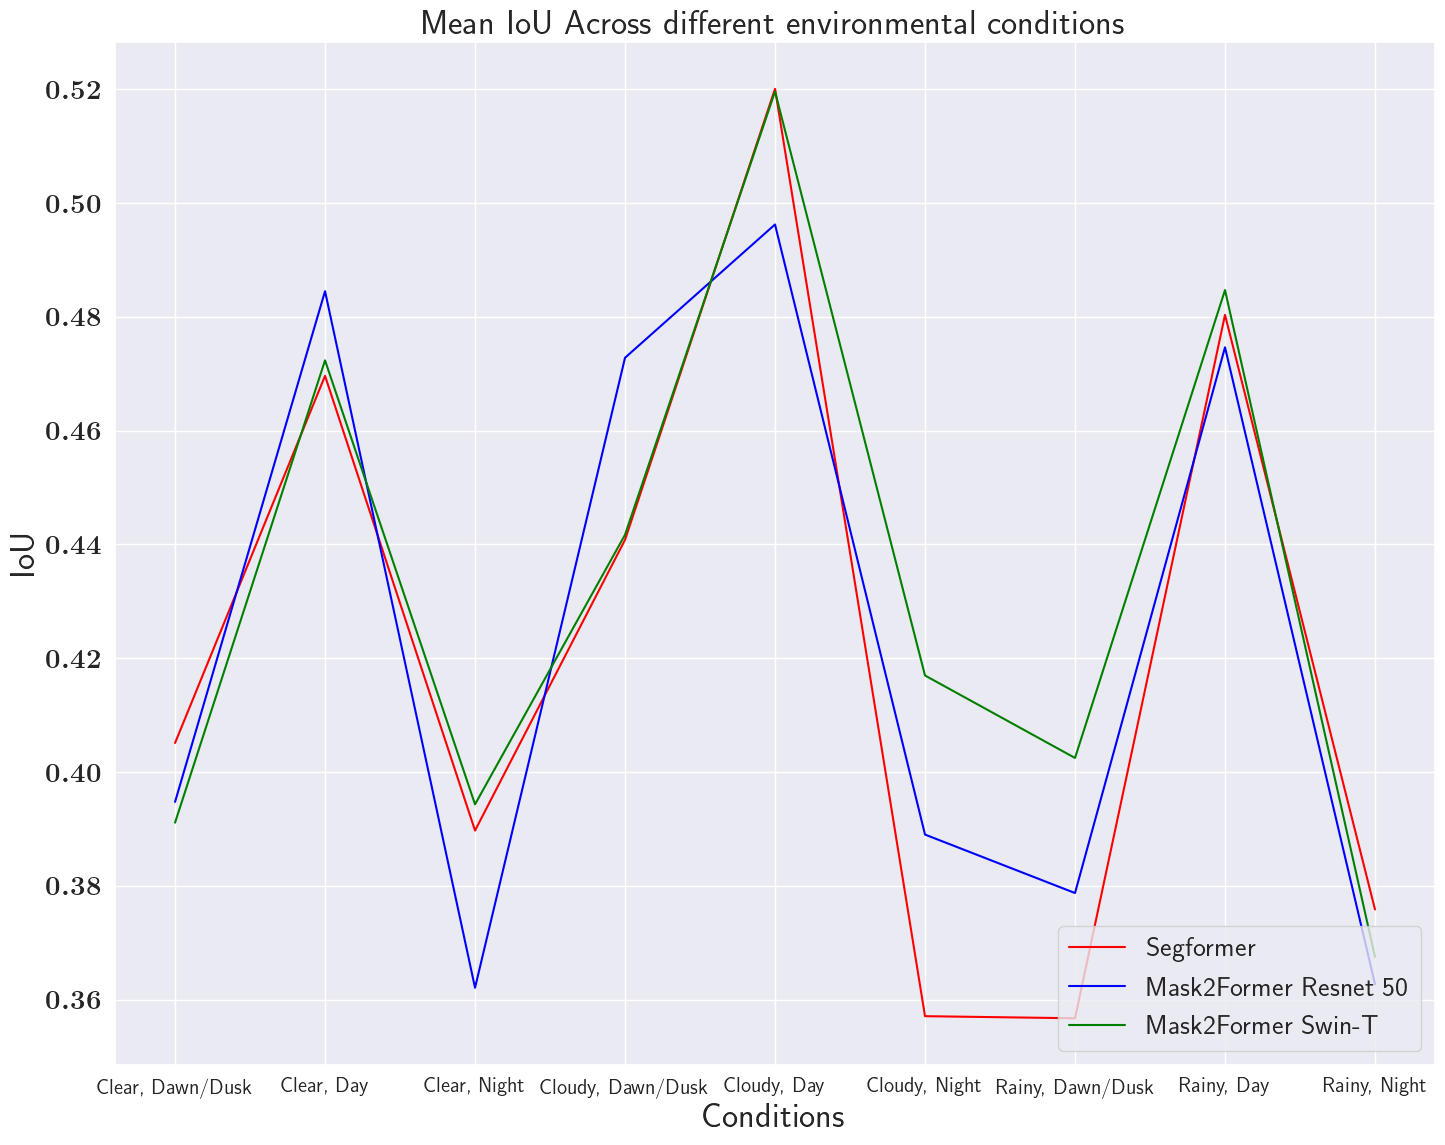

In [50]:
# Line plot of accuracy with respect to conditions
set_plot_properties(
    font_size= 25,
    legend_font_size = 20,
    xtick_label_size = 15,
    ytick_label_size = 20,
    markersize = 15,
    usetex = True,
)
# Creating a box plot for accuracy of each ltl_group, differentiated by model
fig, ax = plt.subplots(figsize=(15, 12))

lineplot(all_data_original,
                    x='condition',
                    y='IoU', 
                    hue='model_cat', 
                    palette=pallete,
                    ax=ax)
plt.legend(fontsize=20, loc='lower right')
plt.title('Mean IoU Across different environmental conditions', fontsize=25)
plt.ylabel('IoU', fontsize=25)
plt.xlabel('Conditions', fontsize=25)



# Plot performance of all trained models


In [41]:
# Formatting data plot items
for model, data in data_plot.items():
    print(model)
    data['model'] = model
    # print(data.columns)
    # print(data.index)
    data.reset_index(inplace=True)

    if 'mask2former_swin' in model:
        data['model_cat'] = 'Mask2Former Swin-T' 
    elif 'mask2former_r50' in model:
        data['model_cat'] = 'Mask2Former Resnet 50' 
    elif 'segformer' in model:
        data['model_cat'] = 'Segformer'
    
    if 'synth' in model:
        data['dataset'] = 'Synthetic'
    elif 'mixed' in model:
        data['dataset'] = 'Mixed'
    else:
        data['dataset'] = 'Real'
    print(data.index)
    print(data.columns)
        
pallete = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
all_data = pd.concat([dfs for dfs in data_plot.values()], ignore_index=True)
model_idxs = {'r50':[],'swin':[],'segformer':[]}

# store the indices of the models which contain the keys

for idx, model in enumerate(all_data['model']):
    if 'r50' in model:
        model_idxs['r50'].append(idx)
    elif 'swin' in model:
        model_idxs['swin'].append(idx)
    elif 'segformer' in model:
        model_idxs['segformer'].append(idx)
    else:
        print('Model not found')

segformer_mit-b3_8xb2-160k_waymo-512x512
RangeIndex(start=0, stop=9, step=1)
Index(['index', 'condition', 'accuracy', 'IoU', 'Dice', 'F1', 'model',
       'model_cat', 'dataset'],
      dtype='object')
mask2former_r50_8xb2-90k_mixedwaymo-512x512
RangeIndex(start=0, stop=9, step=1)
Index(['index', 'condition', 'accuracy', 'IoU', 'Dice', 'F1', 'model',
       'model_cat', 'dataset'],
      dtype='object')
mask2former_swin-t_8xb2-160k_synthwaymo-512x512
RangeIndex(start=0, stop=9, step=1)
Index(['index', 'condition', 'accuracy', 'IoU', 'Dice', 'F1', 'model',
       'model_cat', 'dataset'],
      dtype='object')
mask2former_r50_8xb2-90k_waymo-512x512
RangeIndex(start=0, stop=9, step=1)
Index(['index', 'condition', 'accuracy', 'IoU', 'Dice', 'F1', 'model',
       'model_cat', 'dataset'],
      dtype='object')
mask2former_swin-t_8xb2-160k_mixedwaymo-512x512
RangeIndex(start=0, stop=9, step=1)
Index(['index', 'condition', 'accuracy', 'IoU', 'Dice', 'F1', 'model',
       'model_cat', 'dataset'

Plots for model:  r50
                                          model         condition  accuracy  \
9   mask2former_r50_8xb2-90k_mixedwaymo-512x512  Clear, Dawn/Dusk  0.974411   
9   mask2former_r50_8xb2-90k_mixedwaymo-512x512  Clear, Dawn/Dusk   0.70793   
9   mask2former_r50_8xb2-90k_mixedwaymo-512x512  Clear, Dawn/Dusk       0.0   
9   mask2former_r50_8xb2-90k_mixedwaymo-512x512  Clear, Dawn/Dusk       0.0   
9   mask2former_r50_8xb2-90k_mixedwaymo-512x512  Clear, Dawn/Dusk       0.0   
..                                          ...               ...       ...   
53  mask2former_r50_8xb2-90k_synthwaymo-512x512      Rainy, Night  0.120494   
53  mask2former_r50_8xb2-90k_synthwaymo-512x512      Rainy, Night  0.308731   
53  mask2former_r50_8xb2-90k_synthwaymo-512x512      Rainy, Night  0.654402   
53  mask2former_r50_8xb2-90k_synthwaymo-512x512      Rainy, Night  0.788701   
53  mask2former_r50_8xb2-90k_synthwaymo-512x512      Rainy, Night  0.626715   

      dataset  
9       Mixed

/home/hg22723/anaconda3/envs/control-v11.8/lib/python3.9/site-packages/swarm_visualizer/boxplot.py:59: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.boxplot(


Plots for model:  swin
                                              model         condition  \
18  mask2former_swin-t_8xb2-160k_synthwaymo-512x512  Clear, Dawn/Dusk   
18  mask2former_swin-t_8xb2-160k_synthwaymo-512x512  Clear, Dawn/Dusk   
18  mask2former_swin-t_8xb2-160k_synthwaymo-512x512  Clear, Dawn/Dusk   
18  mask2former_swin-t_8xb2-160k_synthwaymo-512x512  Clear, Dawn/Dusk   
18  mask2former_swin-t_8xb2-160k_synthwaymo-512x512  Clear, Dawn/Dusk   
..                                              ...               ...   
71       mask2former_swin-t_8xb2-160k_waymo-512x512      Rainy, Night   
71       mask2former_swin-t_8xb2-160k_waymo-512x512      Rainy, Night   
71       mask2former_swin-t_8xb2-160k_waymo-512x512      Rainy, Night   
71       mask2former_swin-t_8xb2-160k_waymo-512x512      Rainy, Night   
71       mask2former_swin-t_8xb2-160k_waymo-512x512      Rainy, Night   

    accuracy    dataset  
18  0.977725  Synthetic  
18  0.609439  Synthetic  
18  0.042126  Syntheti

/home/hg22723/anaconda3/envs/control-v11.8/lib/python3.9/site-packages/swarm_visualizer/boxplot.py:59: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.boxplot(


Plots for model:  segformer
                                            model         condition  accuracy  \
0        segformer_mit-b3_8xb2-160k_waymo-512x512  Clear, Dawn/Dusk  0.975812   
0        segformer_mit-b3_8xb2-160k_waymo-512x512  Clear, Dawn/Dusk  0.081303   
0        segformer_mit-b3_8xb2-160k_waymo-512x512  Clear, Dawn/Dusk  0.072687   
0        segformer_mit-b3_8xb2-160k_waymo-512x512  Clear, Dawn/Dusk       0.0   
0        segformer_mit-b3_8xb2-160k_waymo-512x512  Clear, Dawn/Dusk       0.0   
..                                            ...               ...       ...   
80  segformer_mit-b3_8xb2-160k_mixedwaymo-512x512      Rainy, Night  0.156869   
80  segformer_mit-b3_8xb2-160k_mixedwaymo-512x512      Rainy, Night   0.31697   
80  segformer_mit-b3_8xb2-160k_mixedwaymo-512x512      Rainy, Night  0.879393   
80  segformer_mit-b3_8xb2-160k_mixedwaymo-512x512      Rainy, Night  0.694239   
80  segformer_mit-b3_8xb2-160k_mixedwaymo-512x512      Rainy, Night  0.904643   


/home/hg22723/anaconda3/envs/control-v11.8/lib/python3.9/site-packages/swarm_visualizer/boxplot.py:59: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.boxplot(


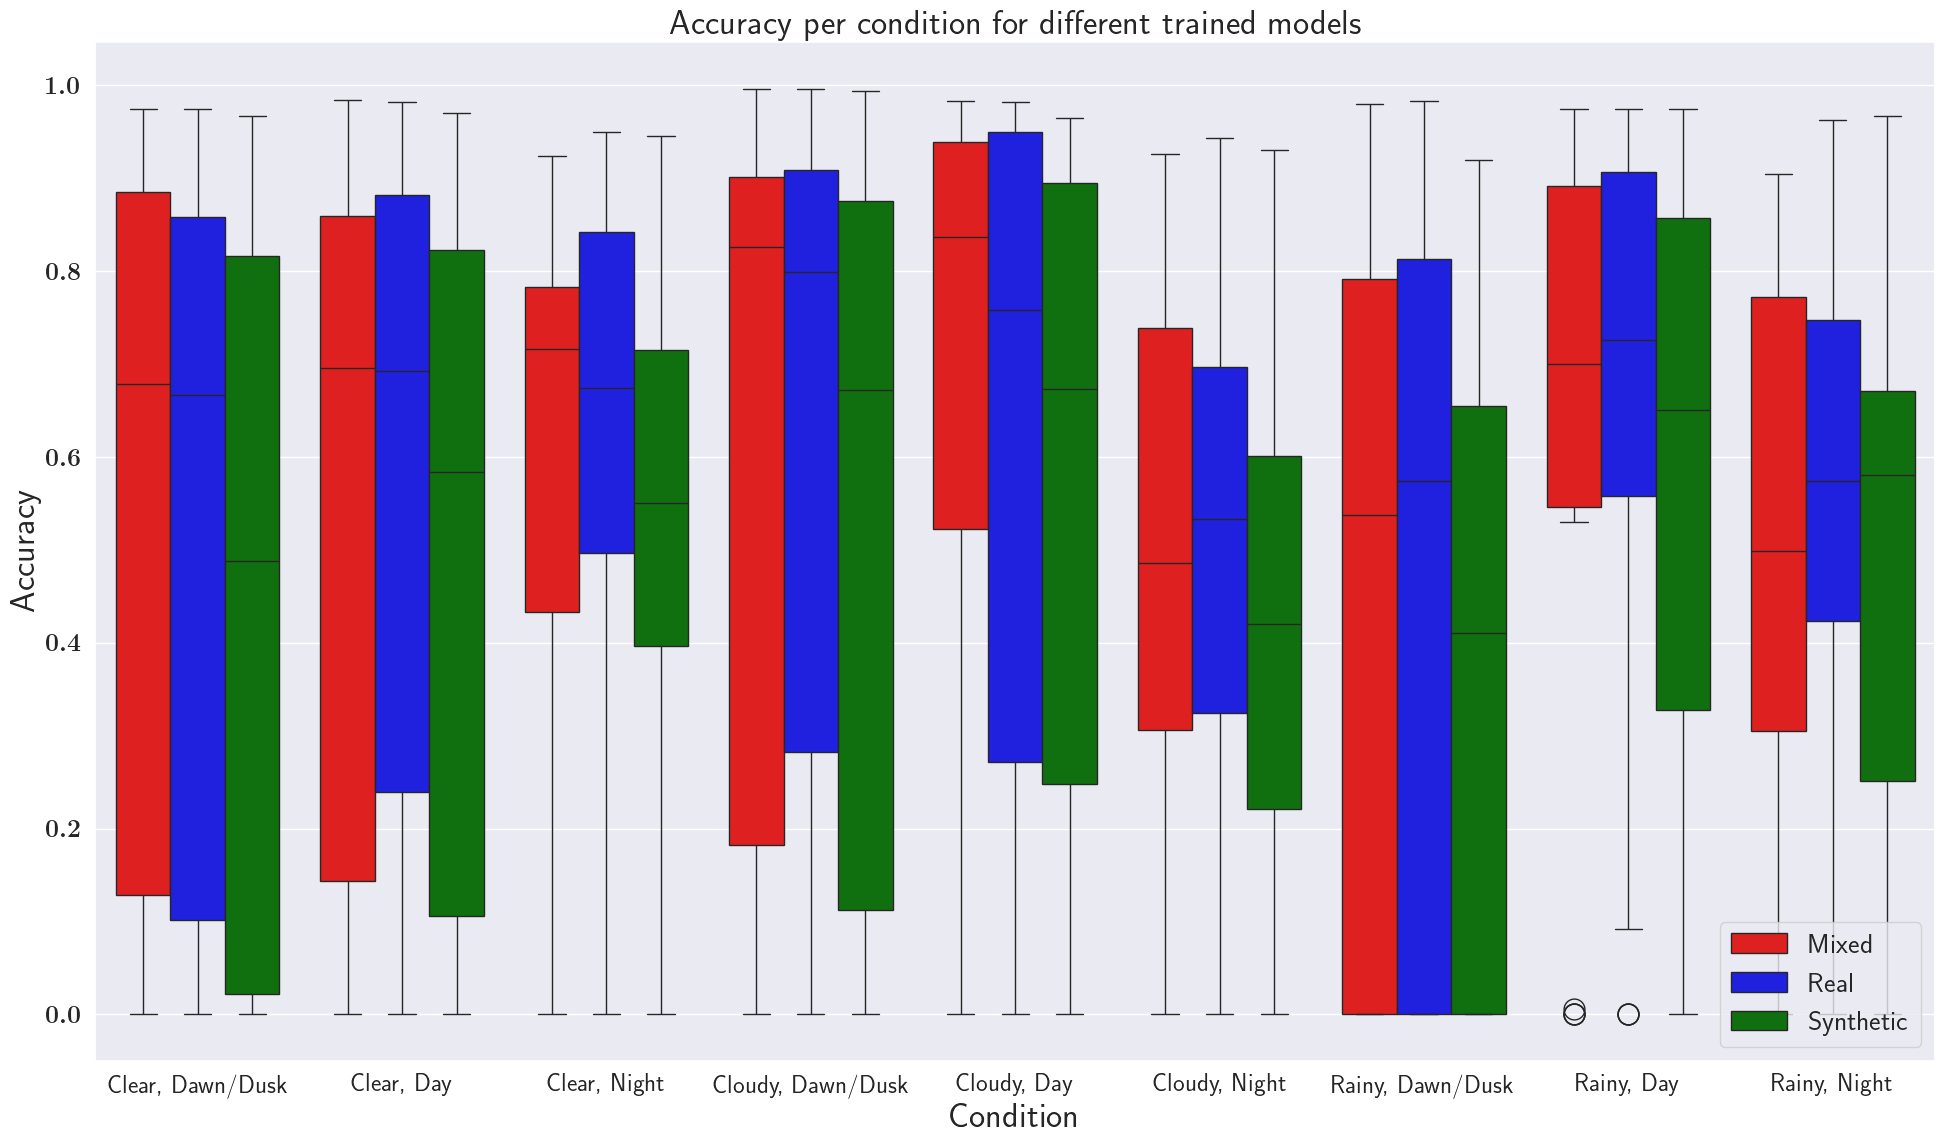

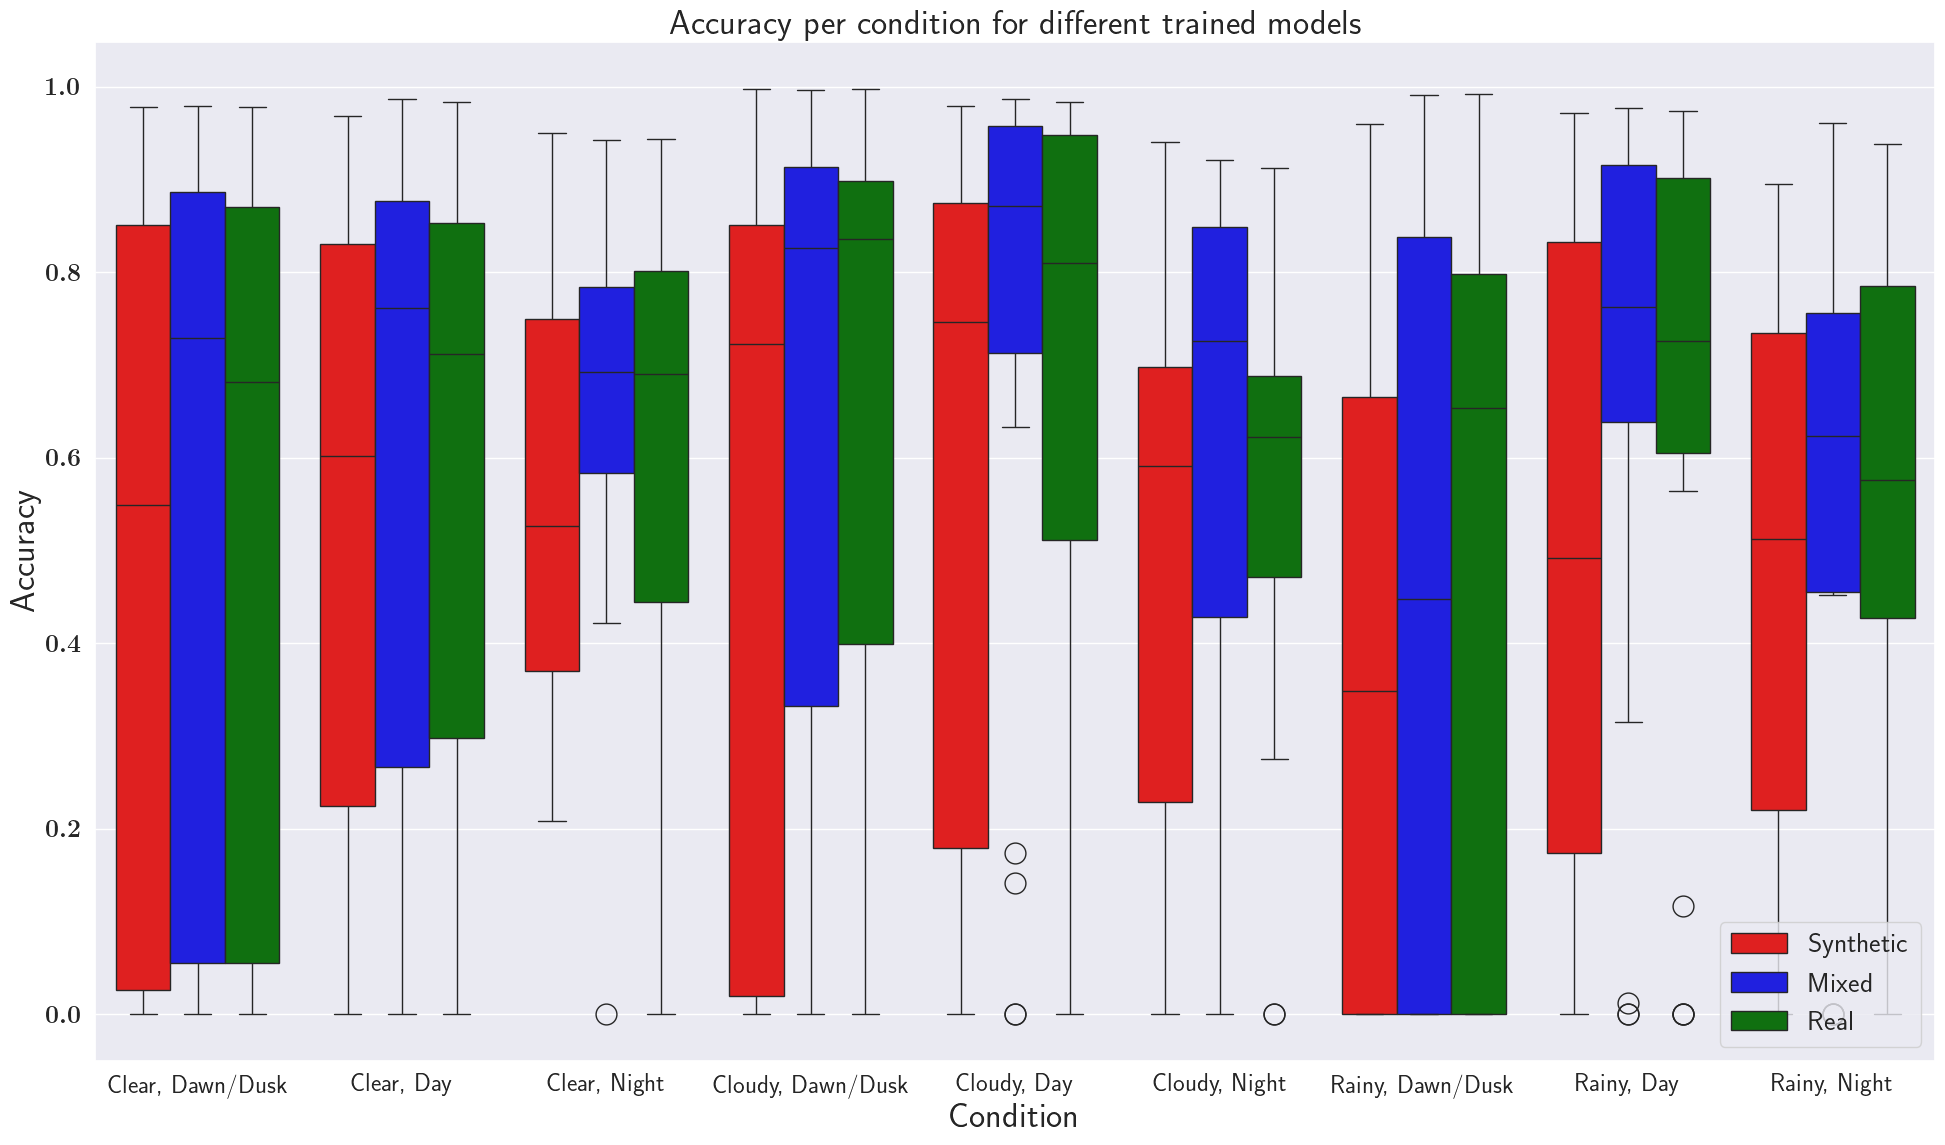

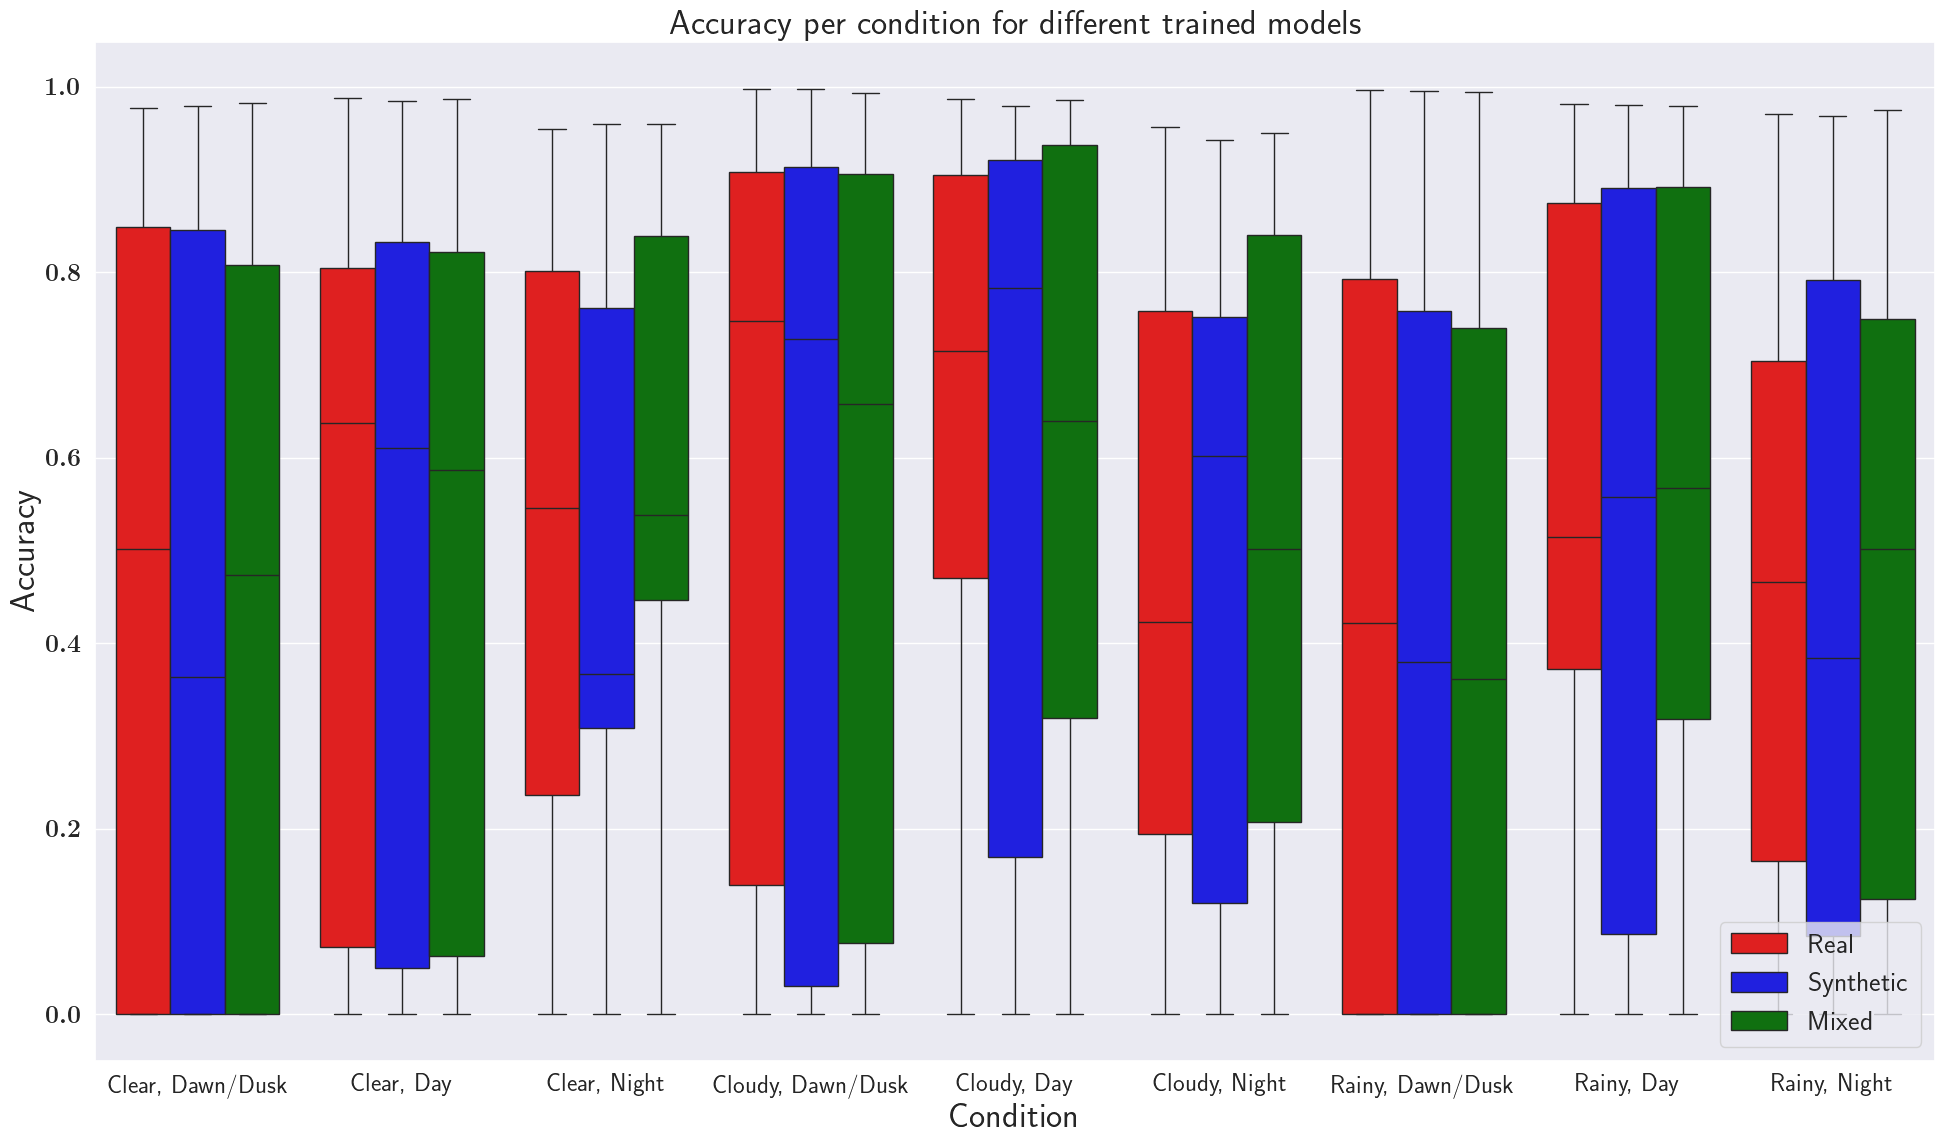

In [42]:
# Plotting the results in a box plot
# Combine the dataframes into a single dataframe in data_plot


for k,v in model_idxs.items():
    print('Plots for model: ', k)
    all_data_acc = pd.DataFrame(columns=['model', 'condition', 'accuracy'])
    all_data_acc['model'] = all_data['model']
    all_data_acc['condition'] = all_data['condition']
    all_data_acc['accuracy'] = all_data['accuracy']
    all_data_acc['dataset'] = all_data['dataset']
    all_data_acc = all_data_acc.iloc[v]
    all_data_acc = all_data_acc.explode('accuracy')

    print(all_data_acc)
    set_plot_properties(
        font_size= 25,
        legend_font_size = 20,
        xtick_label_size = 20,
        ytick_label_size = 20,
        markersize = 15,
        usetex = True,
    )
    # Creating a box plot for accuracy of each ltl_group, differentiated by model
    fig, ax = plt.subplots(figsize=(20, 12))
    plot_paired_boxplot(all_data_acc,
                        x_var='condition',
                        y_var='accuracy', 
                        hue='dataset', 
                        pal=pallete,
                        title_str = 'Accuracy per conditions',
                        ax=ax)
    plt.legend(fontsize=20, loc='lower right')
    plt.title('Accuracy per condition for different trained models', fontsize=25)
    plt.ylabel('Accuracy', fontsize=25)
    plt.xlabel('Condition', fontsize=25)


Plots for model:  r50


/tmp/ipykernel_2247650/3794822374.py:34: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.boxplot(all_data_iou,


Plots for model:  swin


/tmp/ipykernel_2247650/3794822374.py:34: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.boxplot(all_data_iou,


Plots for model:  segformer


/tmp/ipykernel_2247650/3794822374.py:34: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.boxplot(all_data_iou,


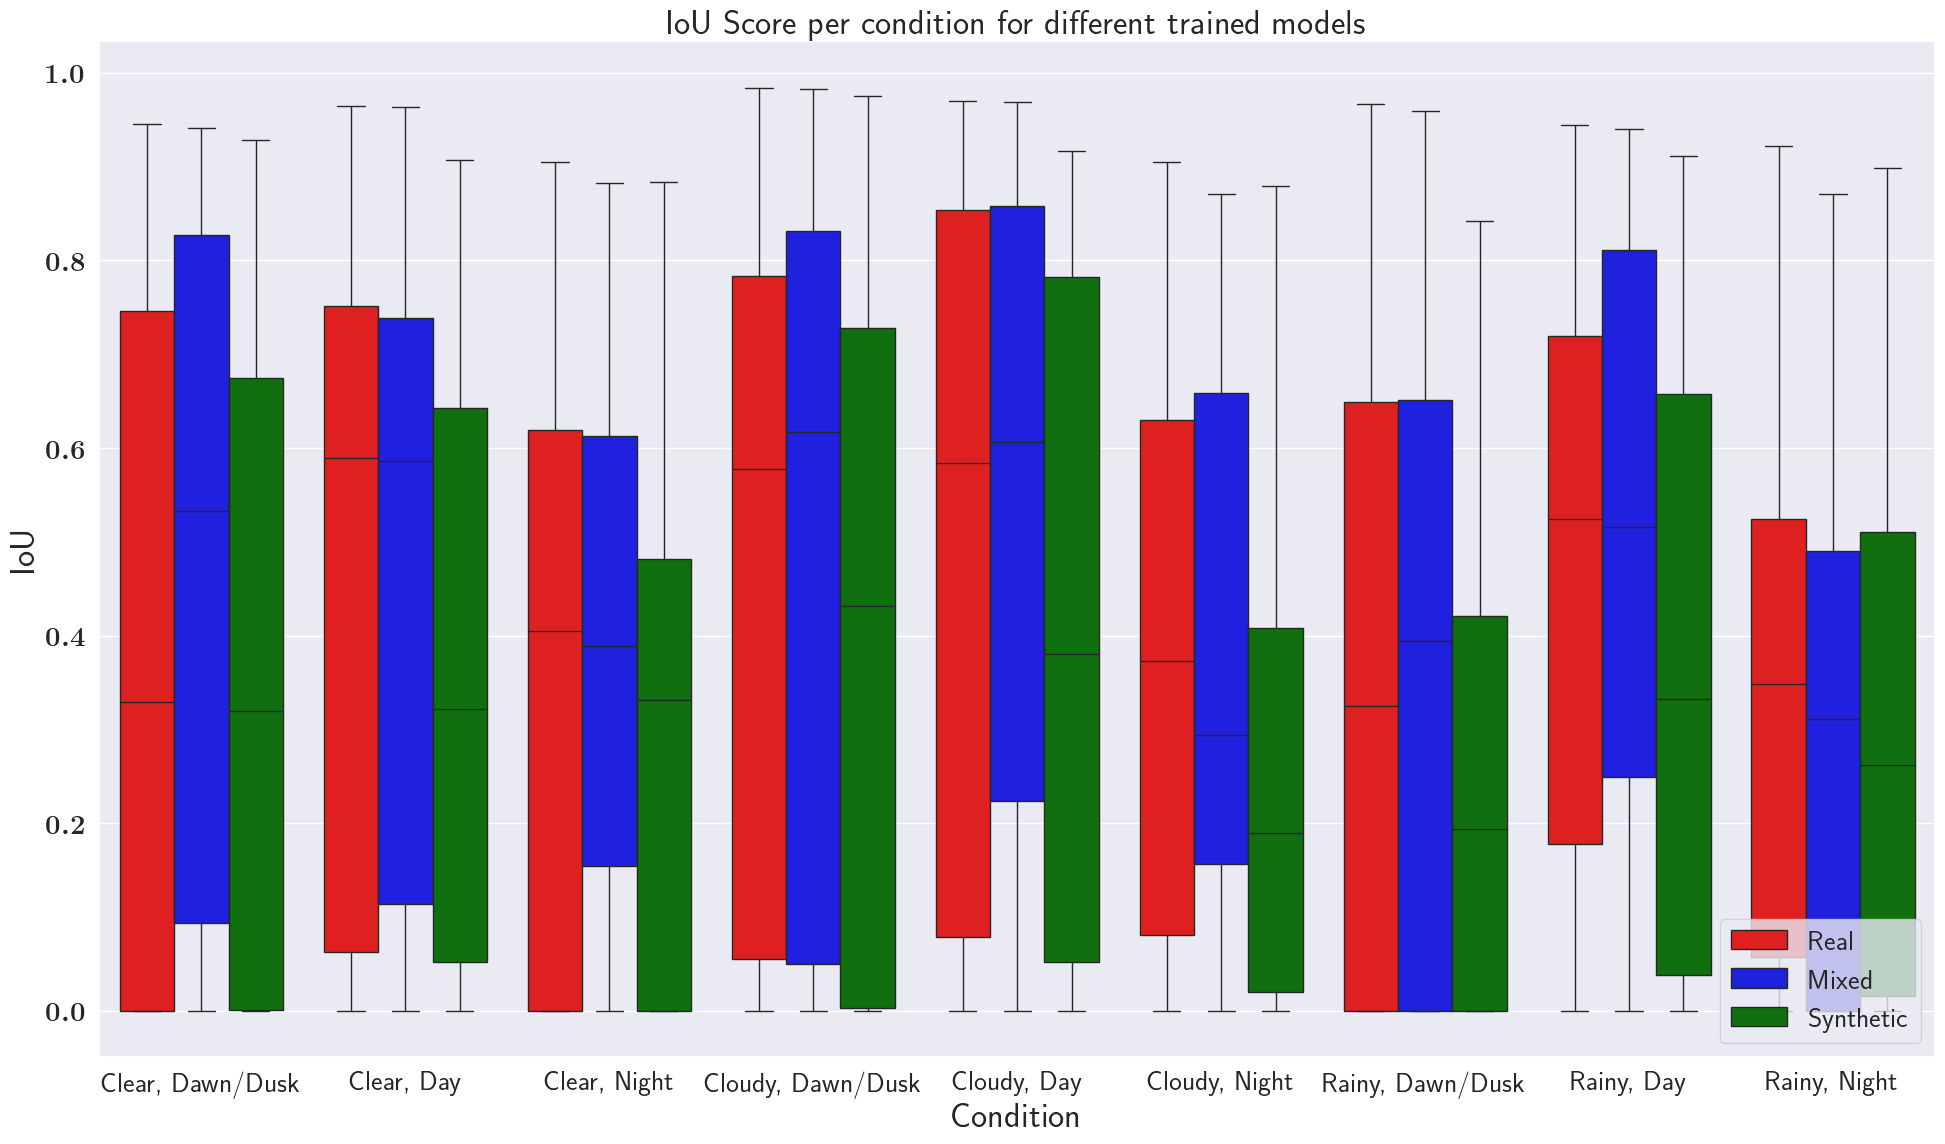

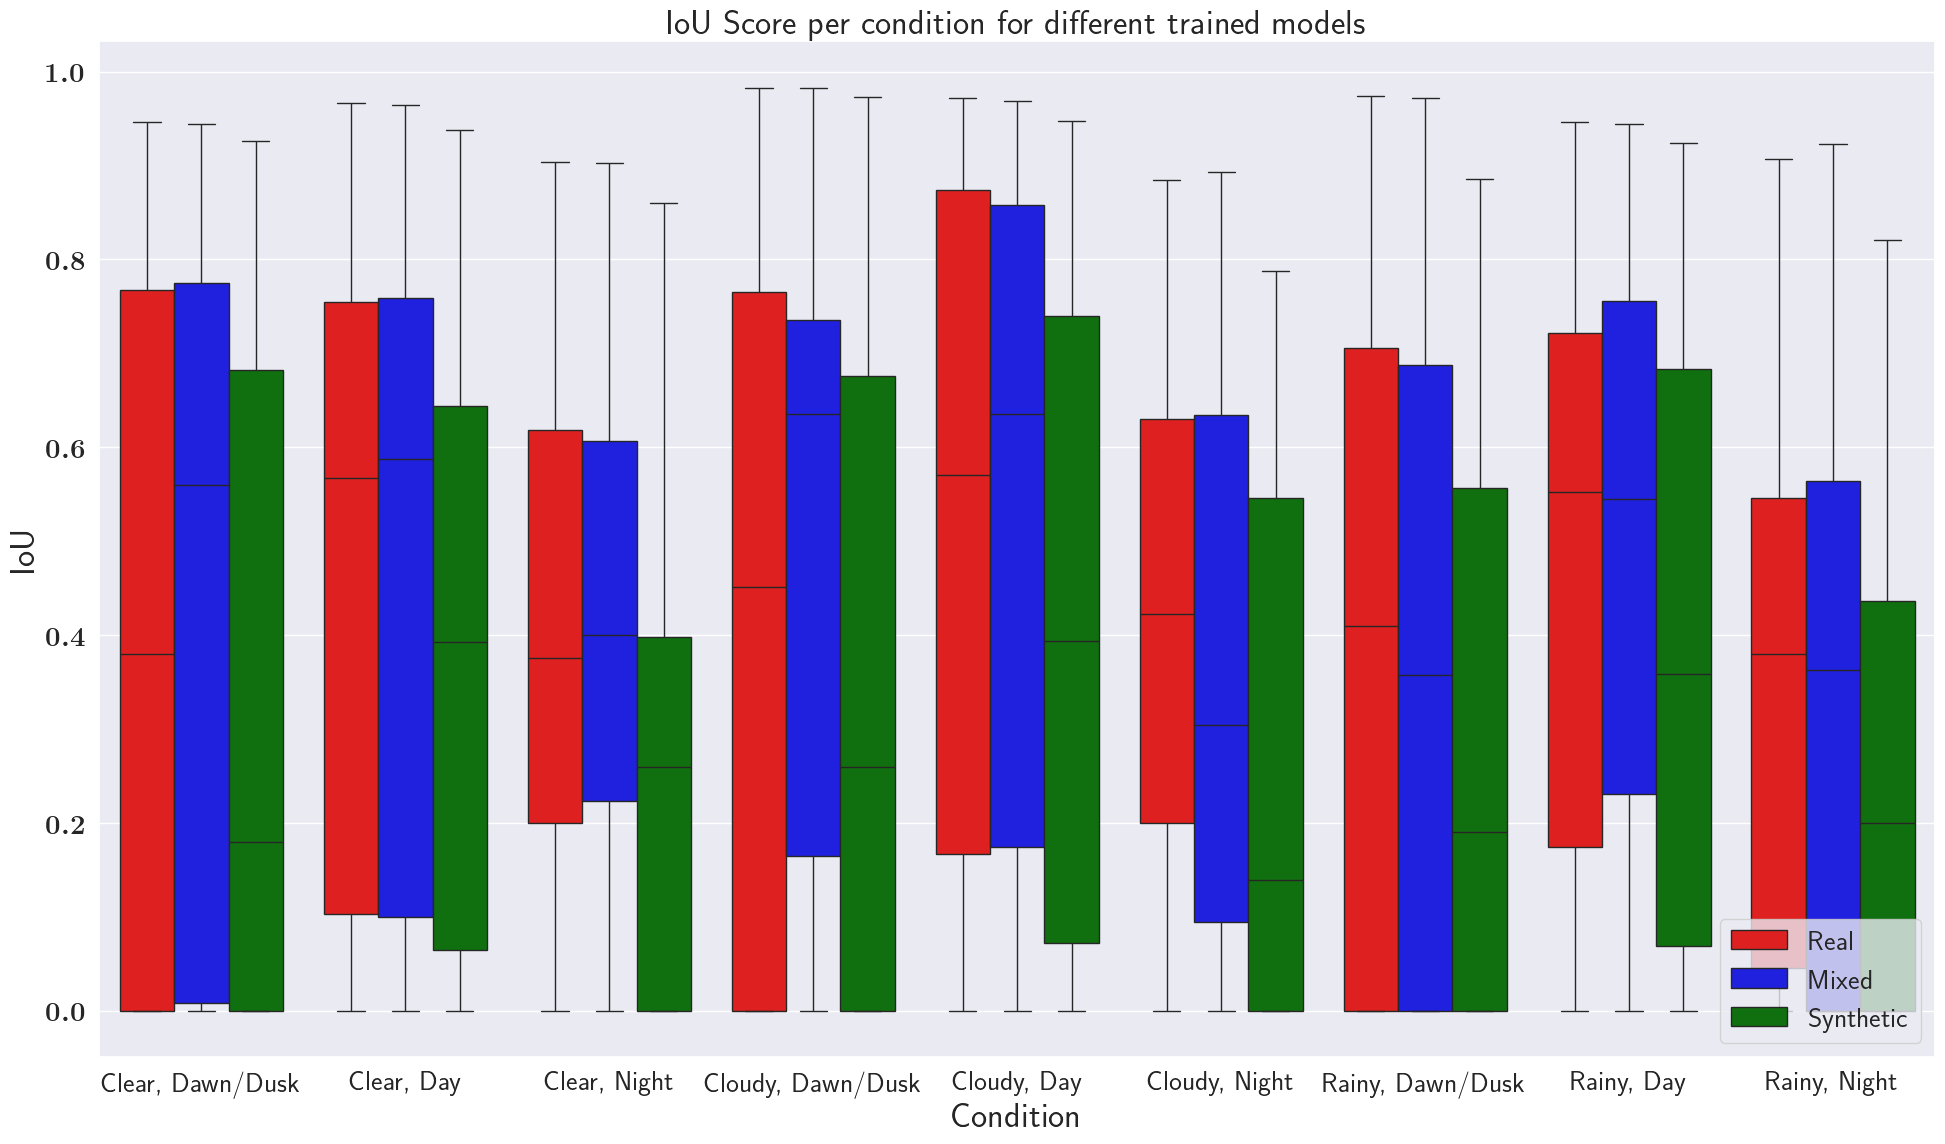

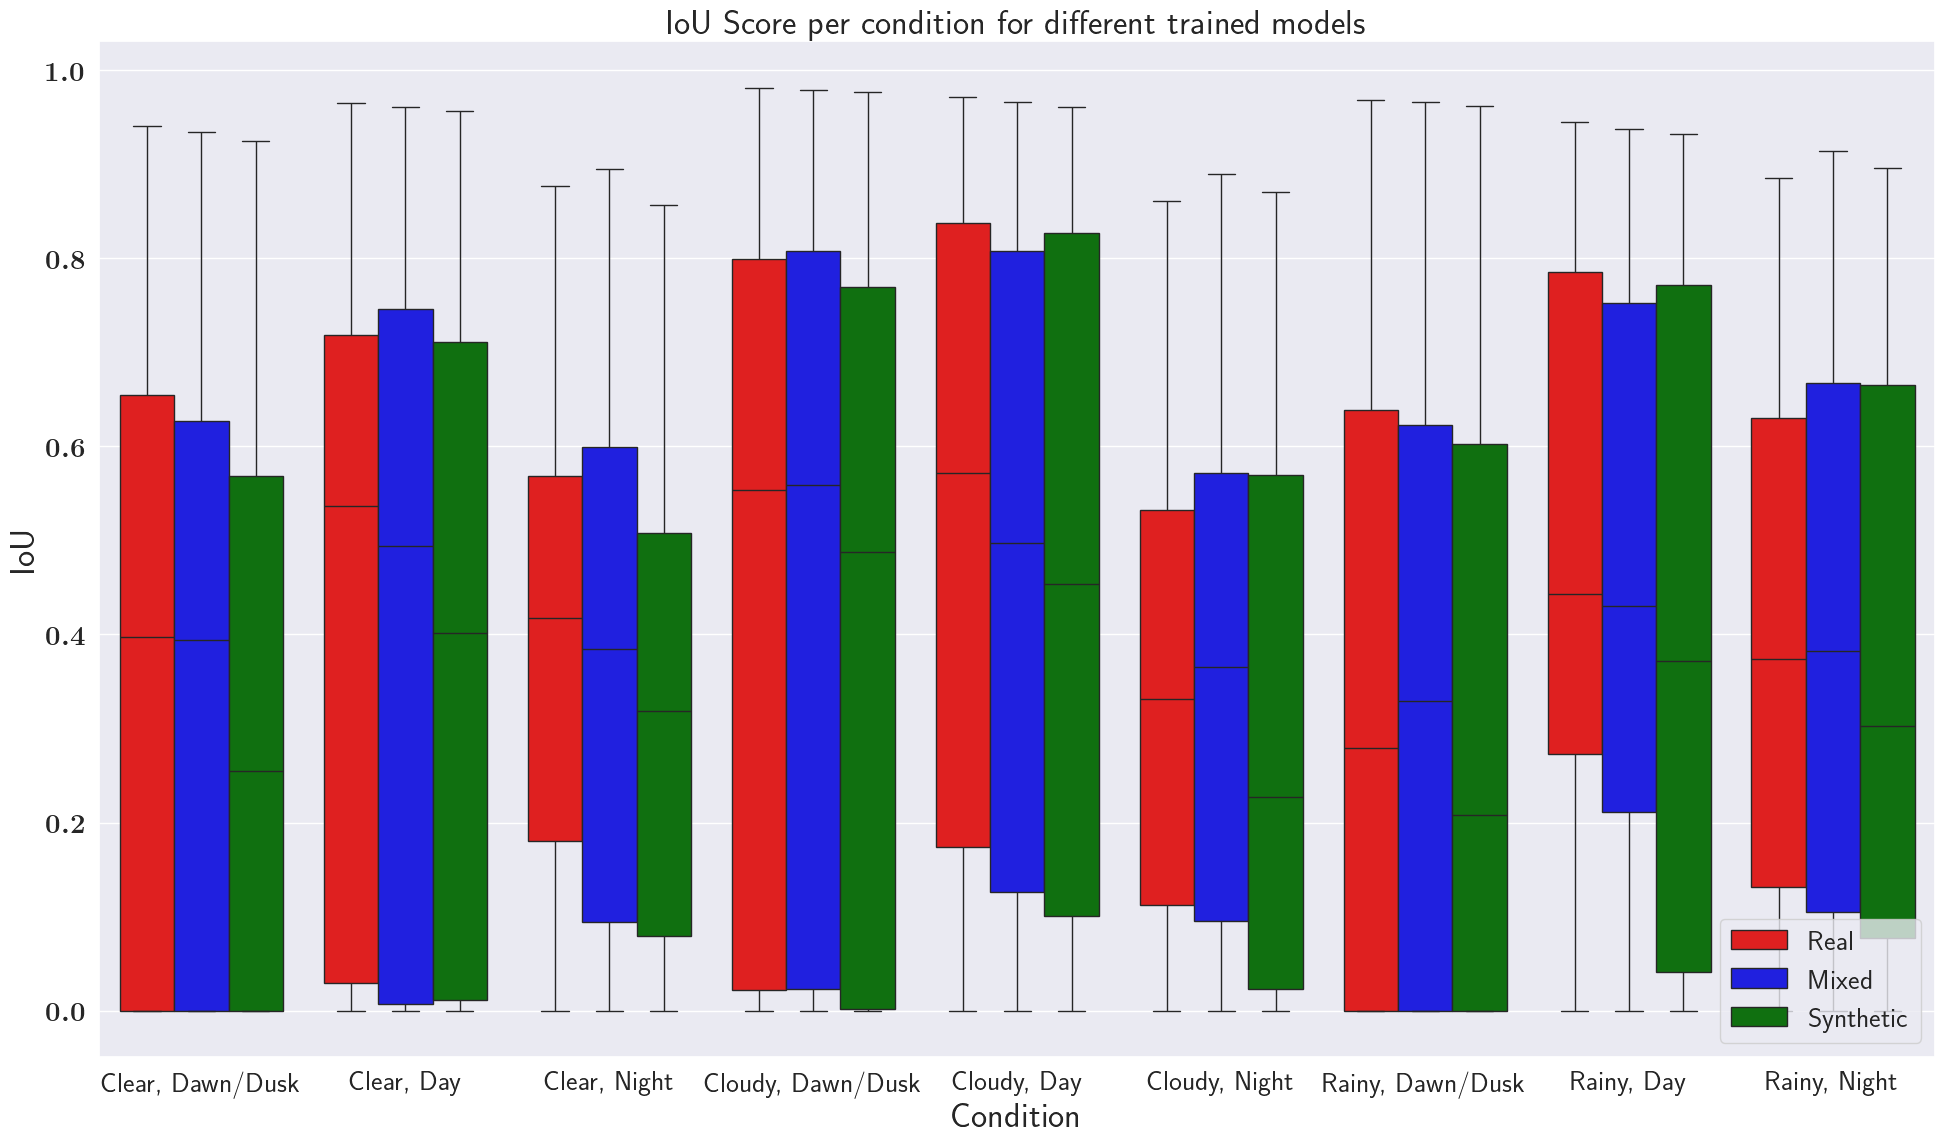

In [46]:
order = ['Real','Mixed','Synthetic']
for k,v in model_idxs.items():
    print('Plots for model: ', k)
    all_data_iou = pd.DataFrame(columns=['model', 'condition', 'IoU'])
    all_data_iou['model'] = all_data['model']
    all_data_iou['condition'] = all_data['condition']
    all_data_iou['IoU'] = all_data['IoU']
    all_data_iou['dataset'] = all_data['dataset']
    all_data_iou = all_data_iou.iloc[v]

    all_models = list(all_data_iou['model'].unique())
    
    hue_order = []
    j=0
    # sort by order
    # for i in order:
    #     for model in all_models:
    #         if i in model:
    #             hue_order.append(model)
    #             all_models.remove(model)
    hue_order = order
    
    all_data_iou = all_data_iou.explode('IoU')
    set_plot_properties(
        font_size= 25,
        legend_font_size = 20,
        xtick_label_size = 20,
        ytick_label_size = 20,
        markersize = 15,
        usetex = True,
    )
    # Creating a box plot for accuracy of each ltl_group, differentiated by model
    fig, ax = plt.subplots(figsize=(20, 12))
    sns.boxplot(all_data_iou,
                        x='condition',
                        y='IoU', 
                        hue='dataset', 
                        palette=pallete,
                        hue_order=hue_order,
                        ax=ax)
    plt.legend(fontsize=20, loc='lower right')
    plt.title('IoU Score per condition for different trained models', fontsize=25)
    plt.ylabel('IoU', fontsize=25)
    plt.xlabel('Condition', fontsize=25)



NameError: name 'all_data_iou' is not defined

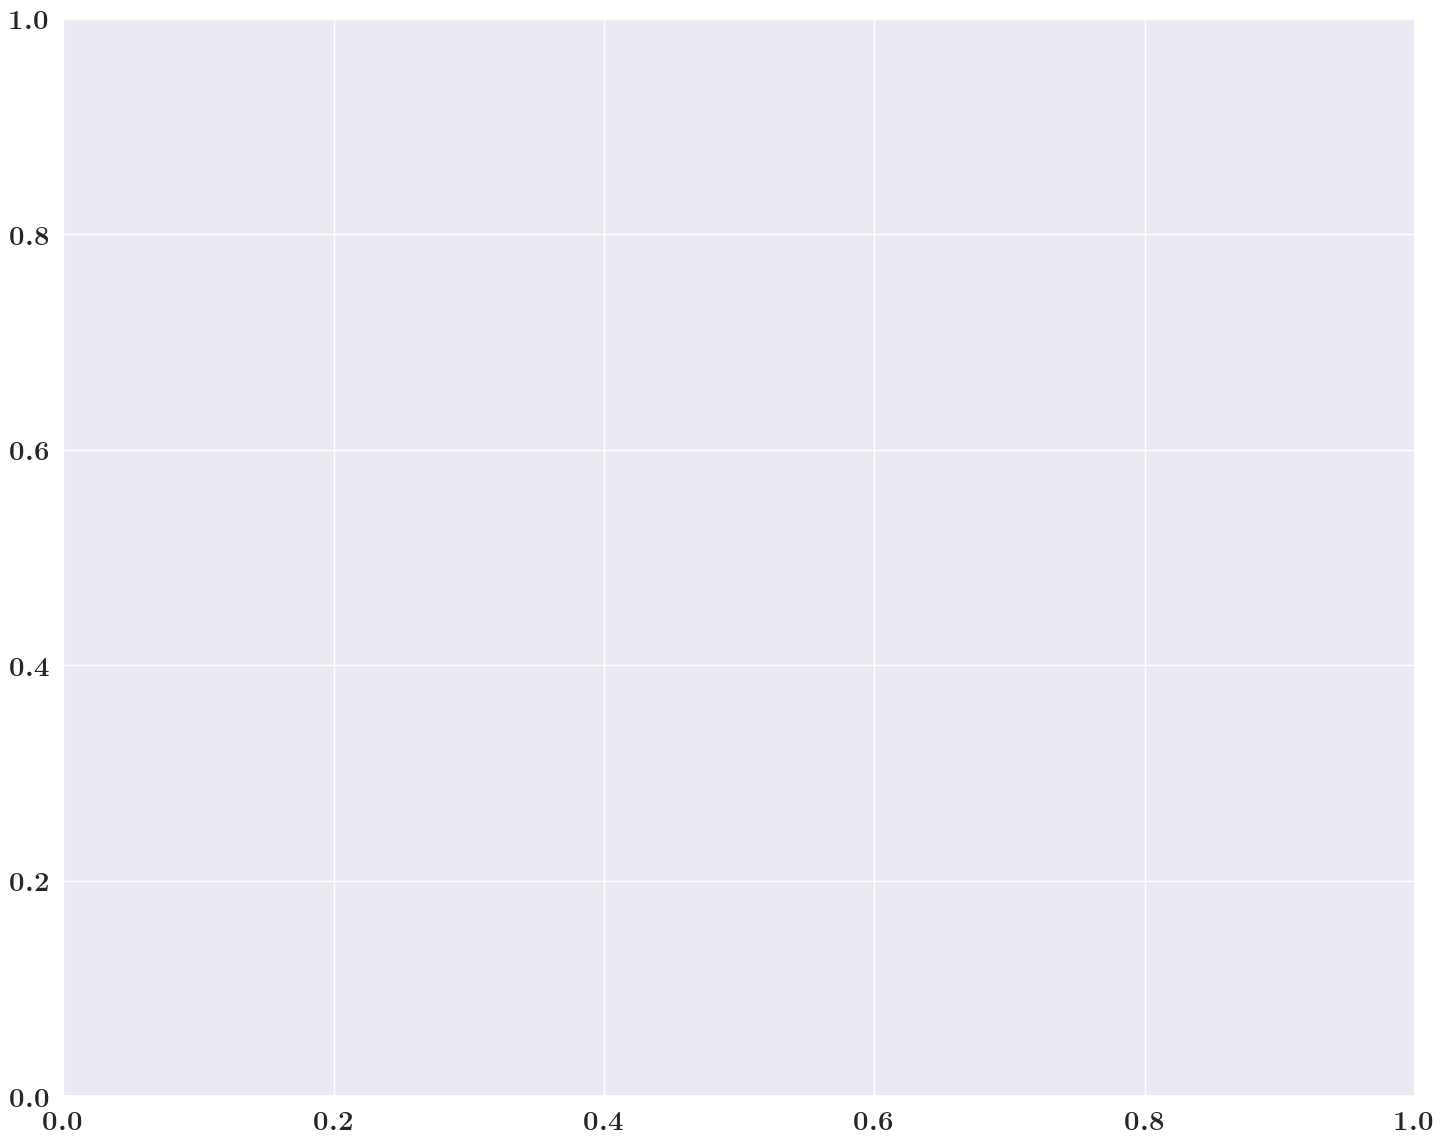

In [43]:
all_data_dice = pd.DataFrame(columns=['model', 'condition', 'Dice'])
all_data_dice['model'] = all_data['model']
all_data_dice['condition'] = all_data['condition']
all_data_dice['Dice'] = all_data['Dice']

set_plot_properties(
    font_size= 25,
    legend_font_size = 20,
    xtick_label_size = 20,
    ytick_label_size = 20,
    markersize = 15,
    usetex = True,
)
# Creating a box plot for accuracy of each ltl_group, differentiated by model
fig, ax = plt.subplots(figsize=(15, 12))
plot_paired_boxplot(all_data_iou,
                    x_var='condition',
                    y_var='Dice', 
                    hue='model', 
                    pal=pallete,
                    title_str = 'F1 Score per LTL Group by Different Retrieval Models',
                    ax=ax)
plt.legend(fontsize=20, loc='lower right')
plt.title('F1 Score per TL Specification by Different Retrieval Algorithms', fontsize=25)
plt.ylabel('F1 Score', fontsize=25)
plt.xlabel('TL Specification', fontsize=25)


In [ ]:
all_data_f1 = pd.DataFrame(columns=['model', 'condition', 'F1'])
all_data_f1['model'] = all_data['model']
all_data_f1['condition'] = all_data['condition']
all_data_f1['F1'] = all_data['F1']

set_plot_properties(
    font_size= 25,
    legend_font_size = 20,
    xtick_label_size = 20,
    ytick_label_size = 20,
    markersize = 15,
    usetex = True,
)
# Creating a box plot for accuracy of each ltl_group, differentiated by model
fig, ax = plt.subplots(figsize=(15, 12))
plot_paired_boxplot(all_data_iou,
                    x_var='condition',
                    y_var='F1', 
                    hue='model', 
                    pal=pallete,
                    title_str = 'F1 Score per LTL Group by Different Retrieval Models',
                    ax=ax)
plt.legend(fontsize=20, loc='lower right')
plt.title('F1 Score per TL Specification by Different Retrieval Algorithms', fontsize=25)
plt.ylabel('F1 Score', fontsize=25)
plt.xlabel('TL Specification', fontsize=25)


# Correcting the set of conditions


In [8]:
DF_COND = MODEL_DATA[list(MODEL_DATA.keys())[0]]
columns = ['content_name', 'context_frame', 'camera_id','condition']
data = DF_COND[columns]

# Save the data to a compiled CSV file


In [ ]:
print(total_area_intersect.items)
print(len(total_area_intersect))